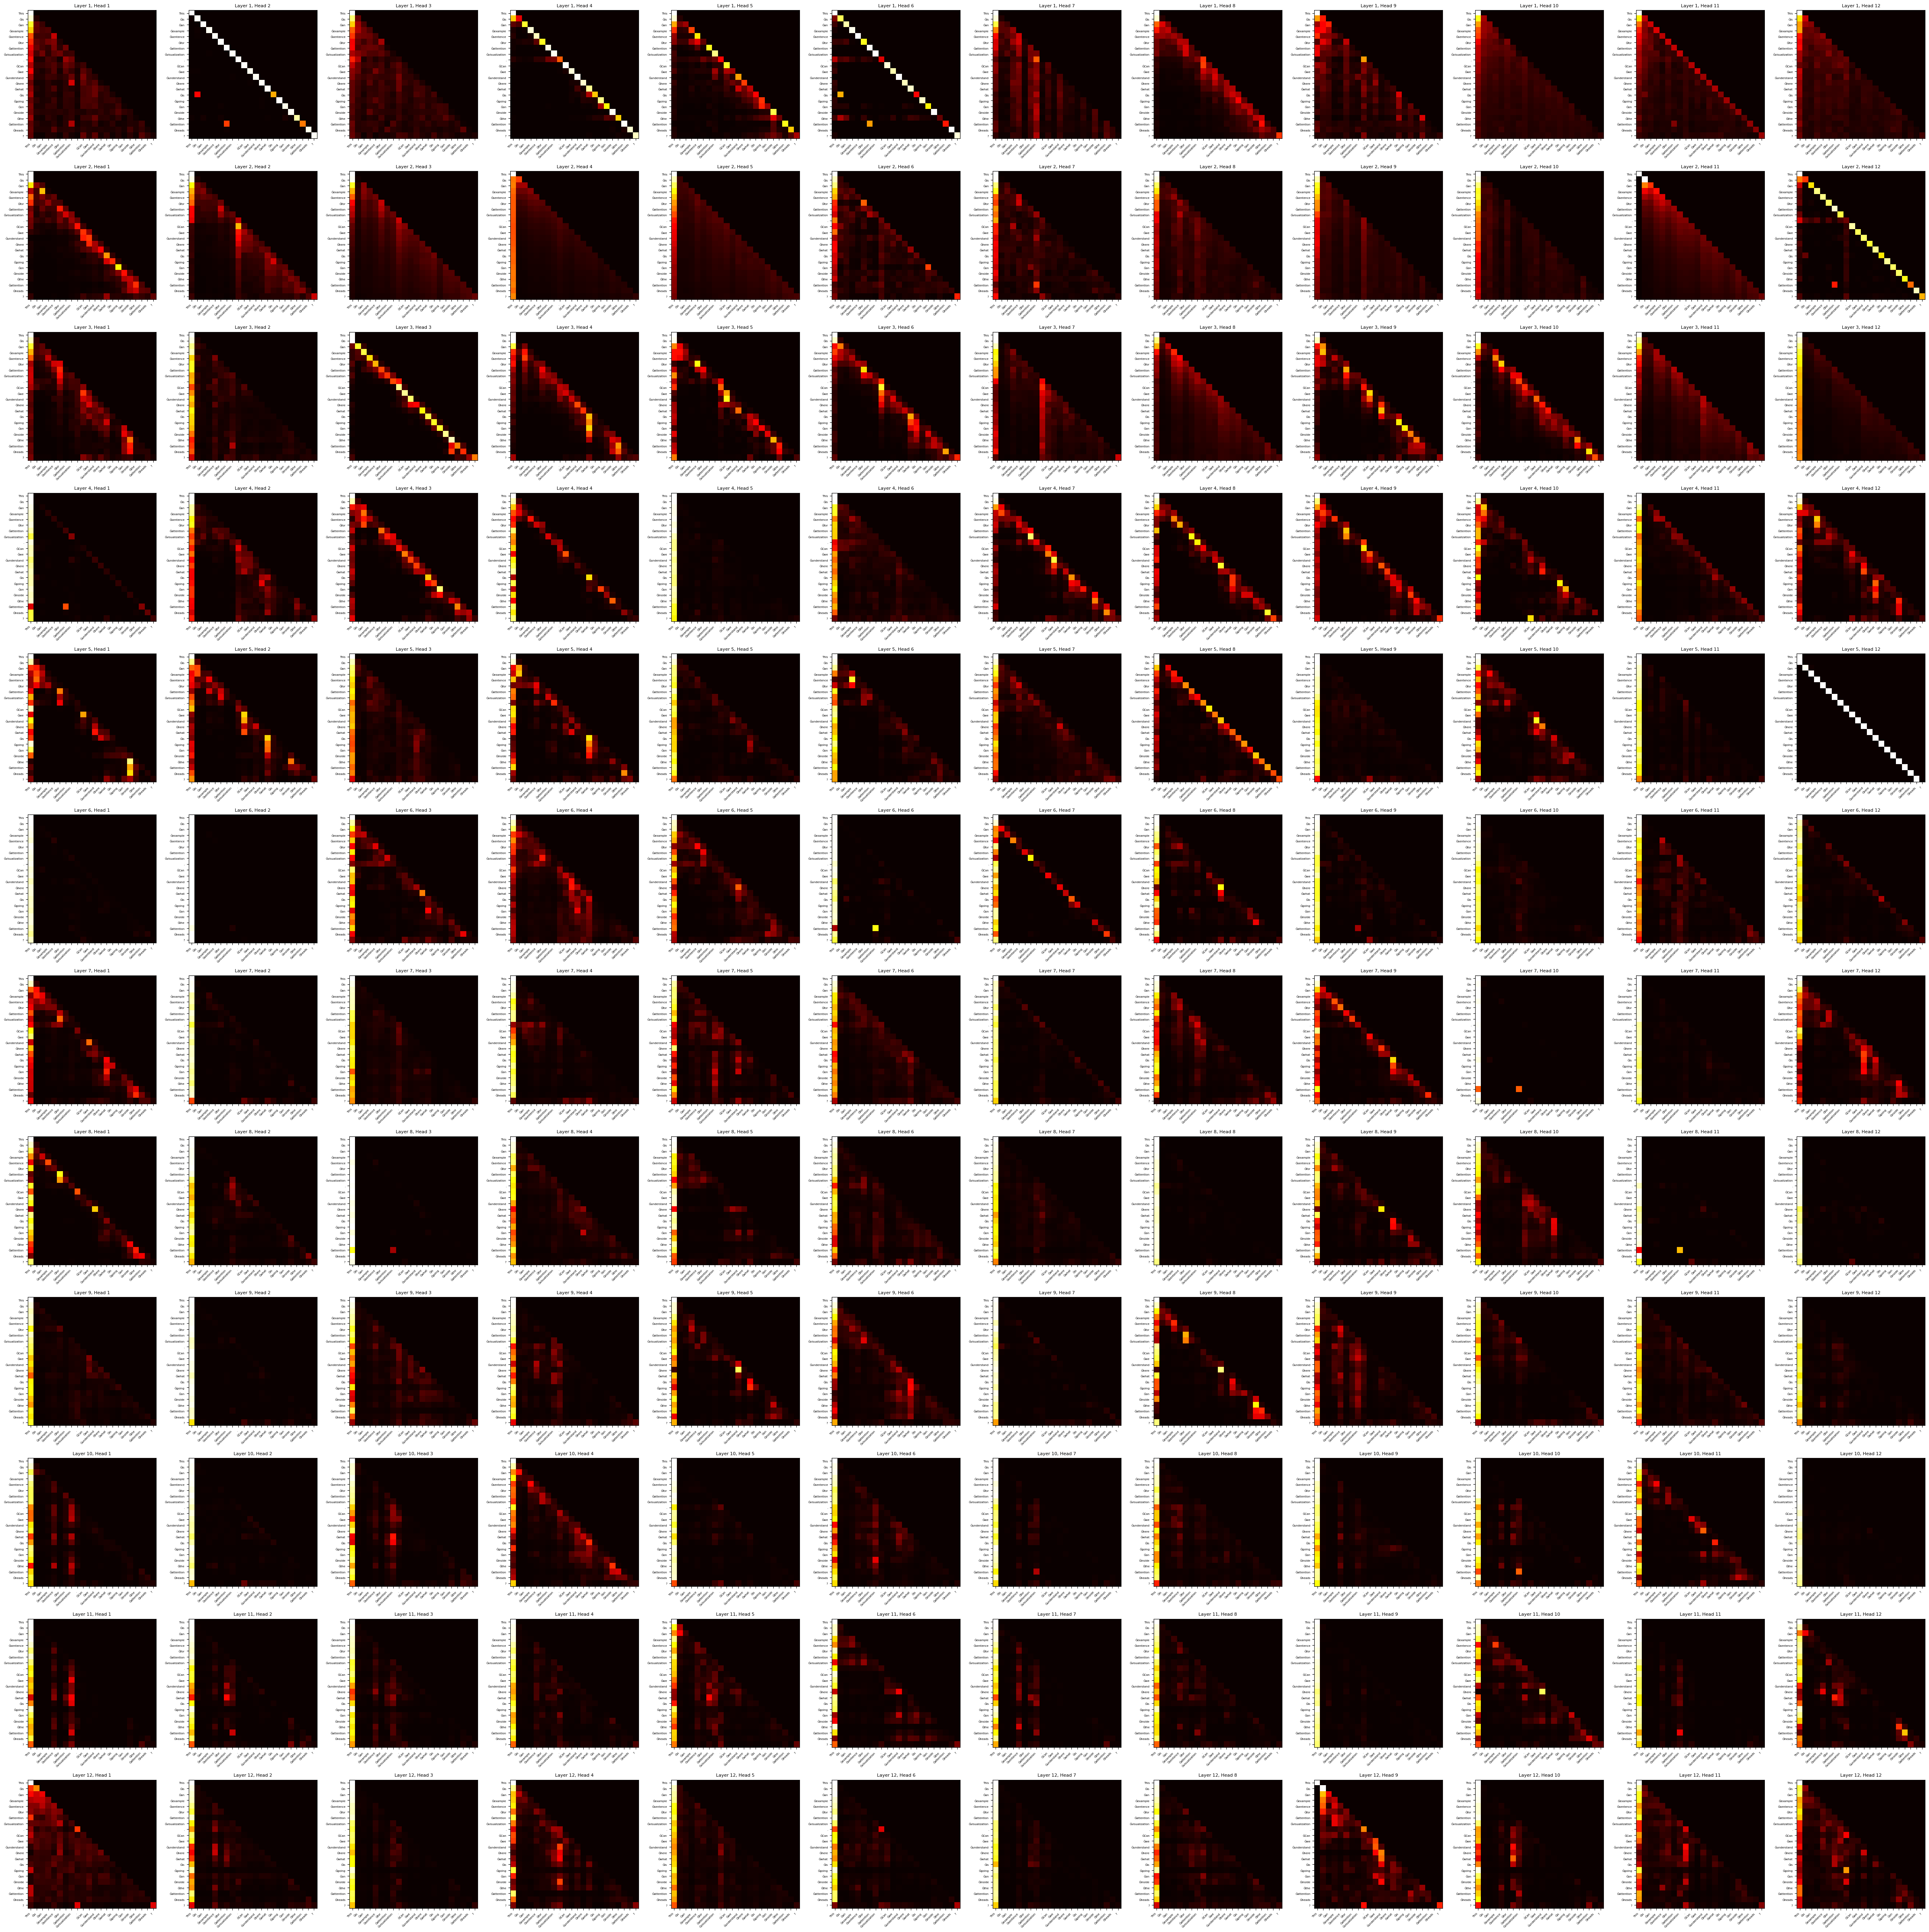

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

model = GPT2Model.from_pretrained("gpt2")

# Input sentence
sentence = "This is an example sentence for attention visualization. Can we understand here what is going on inside the attention heads?"

# Tokenize input
tokens = tokenizer.tokenize(sentence)

inputs = tokenizer.encode_plus(sentence, return_tensors="pt", add_special_tokens=True)

# Get attention weights
outputs = model(**inputs, output_attentions=True)  # Enable output attentions

attention = outputs.attentions

# Concatenate attention matrices from all attention heads
attention_matrix = torch.cat(attention, dim=0).squeeze(1)

num_layers, num_heads, seq_len, _ = attention_matrix.shape

fig, axs = plt.subplots(num_layers, num_heads, figsize=(48, 48))

for layer in range(num_layers):
    for head in range(num_heads):
        attention_weights_head = attention_matrix[layer, head].detach().numpy()
        axs[layer, head].imshow(attention_weights_head, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
        axs[layer, head].set_xticks(range(len(tokens)))
        axs[layer, head].set_xticklabels(tokens, rotation=45, ha='right', fontsize=5)  # Adjust the fontsize
        axs[layer, head].set_yticks(range(len(tokens)))
        axs[layer, head].set_yticklabels(tokens, fontsize=5)  # Adjust the fontsize
        axs[layer, head].set_title(f"Layer {layer+1}, Head {head+1}", fontsize=8)  # Adjust the fontsize

plt.tight_layout()
plt.savefig("attention_plot.png", dpi=300)
plt.show()

In [ ]:
import os
import datetime

def plot_heatmaps(data, output_folder, title_font_size=12, subtitle_font_size=10, figsize=(120, 40), dpi=100,
                  row_spacing=0.2, column_spacing=0.2, title_spacing=0.4, subtitle_spacing=0.3, tick_font_size=8):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Retrieve the keys of the linear layers
    linear_layer_keys = [key for key in data.keys() if key.endswith('.weight')]

    # Calculate the number of linear layers and heads
    num_layers = len(linear_layer_keys) // 4
    num_heads = 4

    # Create the subplot grid
    fig, axes = plt.subplots(num_layers, num_heads, figsize=figsize, dpi=dpi)

    # Adjust the row and column spacing
    fig.subplots_adjust(hspace=row_spacing, wspace=column_spacing, top=1 - title_spacing / figsize[1])

    # Iterate over the linear layers and plot the heatmaps
    for i, layer_key in enumerate(linear_layer_keys):
        # Extract the weights from the layer
        weights = data[layer_key]

        # Move the weights to CPU memory
        weights = weights.cpu()

        # Reshape the weights to 2D
        weights_2d = weights.view(weights.size(0), -1)

        # Convert the weights to a numpy array
        weights_np = weights_2d.detach().numpy()

        # Determine the layer and head indices
        layer_idx = i % num_layers
        head_idx = i // num_layers

        # Plot the heatmap in the corresponding subplot
        axes[layer_idx, head_idx].imshow(weights_np, cmap='hot')
        axes[layer_idx, head_idx].set_title(f"Layer: {layer_idx}\nHead: {head_idx+1}", fontsize=subtitle_font_size,
                                            pad=subtitle_spacing)

        # Set the font size of the ticks
        axes[layer_idx, head_idx].tick_params(axis='both', which='both', labelsize=tick_font_size)

    # Adjust the layout and spacing
    fig.tight_layout()

    # Save the plot with timestamp in the output folder
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    output_path = os.path.join(output_folder, f'heatmaps[{timestamp}].png')
    plt.savefig(output_path, dpi=dpi)
    plt.close(fig)

    print(f"Saved heatmaps at: {output_path}")